In [1]:
import torch
from torch import nn
from torchvision import models
from tqdm import tqdm
from sklearn.model_selection import KFold
import cv2
import random
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import albumentations as A
from torch.utils.data import Dataset,DataLoader
import os
import shutil
from datetime import datetime
from torch.autograd import Variable
from math import floor, ceil, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Optional
from PIL import Image
from torch import Tensor
import glob
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_recall_curve
from torchvision.models import vit_b_16, vit_l_16
from torchvision.models.vision_transformer import ViT_B_16_Weights
import torch.nn.functional as F
from typing import Dict, List
import torch.optim as optim
from torchvision import models
from albumentations import Compose, Resize, Normalize
import torchvision.transforms as T
import random
from torch.utils.data import random_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,recall_score, f1_score, jaccard_score,
                            matthews_corrcoef, balanced_accuracy_score,cohen_kappa_score)
from timm import create_model 
import albumentations as A
import gc
from torch.utils.data import random_split, ConcatDataset

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##### cuda

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset

In [4]:
class LEVIRCDPlus(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms, segment_size=256, max_files=None) -> None: 
        self.root = root
        self.split = split
        self.transforms = transforms
        self.segment_size = segment_size
        self.max_files = max_files

        self.files = self._load_files(self.root, self.split, self.max_files)
        self.num_segments = (1024 // self.segment_size) ** 2 

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        image_idx = index // self.num_segments
        segment_idx = index % self.num_segments 

        files = self.files[image_idx]
        
        image1 = Image.open(files['image1'])
        image2 = Image.open(files['image2'])
        mask = Image.open(files['mask'])

        row = (segment_idx // 4) * self.segment_size
        col = (segment_idx % 4) * self.segment_size

        image1 = image1.crop((col, row, col + self.segment_size, row + self.segment_size))
        image2 = image2.crop((col, row, col + self.segment_size, row + self.segment_size))
        mask = mask.crop((col, row, col + self.segment_size, row + self.segment_size))

        if self.transforms is not None:
            transformed = self.transforms(image=np.array(image1), image0=np.array(image2), mask=np.array(mask))
            image1 = transformed['image'] / 255.0
            image2 = transformed['image0'] / 255.0
            mask = transformed['mask'].unsqueeze(0) / 255.0
        else:
            image1 = torch.tensor(np.array(image1)).permute(2, 0, 1).float() / 255.0 
            image2 = torch.tensor(np.array(image2)).permute(2, 0, 1).float() / 255.0
            mask = torch.tensor(np.array(mask)).float().unsqueeze(0) / 255.0

        x = torch.stack([image1, image2], dim=0)
        return dict(x=x, mask=mask)

    def __len__(self) -> int:
        return len(self.files) * self.num_segments

    def _load_files(self, root, split, max_files=None) -> List[Dict[str, str]]:
        files = []
        images = glob.glob(os.path.join(root, split, 'A', "*.png"))
        images = sorted([os.path.basename(image) for image in images])

        if max_files is not None:
            images = images[:max_files]

        for image in images:
            image1 = os.path.join(root, split, 'A', image)
            image2 = os.path.join(root, split, 'B', image)
            mask = os.path.join(root, split, 'label', image)
            files.append(dict(image1=image1, image2=image2, mask=mask))
        return files

In [5]:
train_transform = A.Compose([Resize(128,128),ToTensorV2()], additional_targets={'image0': 'image'})

test_transform = A.Compose([Resize(128,128),ToTensorV2()], additional_targets={'image0': 'image'})

train_dset = LEVIRCDPlus(
    root="/kaggle/input/s2looking/LEVIR-CD+/LEVIR-CD+",
    split='train', 
    transforms=train_transform,
    segment_size=256  
)

test_dset = LEVIRCDPlus(
    root="/kaggle/input/s2looking/LEVIR-CD+/LEVIR-CD+",
    split='test',
    transforms=test_transform,
    segment_size=256 
)

In [6]:
test_size = len(test_dset) // 2
half_test_dset, test_dset = random_split(test_dset, [test_size, len(test_dset) - test_size])
train_dset = ConcatDataset([train_dset, half_test_dset])

In [7]:
print(f"Train: {len(train_dset)}")
print('x: ', train_dset[0]['x'].shape)
print('mask: ', train_dset[0]['mask'].shape)

print(f"Test: {len(test_dset)}")
print('x: ', test_dset[0]['x'].shape)
print('mask: ', test_dset[0]['mask'].shape)

Train: 12976
x:  torch.Size([2, 3, 128, 128])
mask:  torch.Size([1, 128, 128])
Test: 2784
x:  torch.Size([2, 3, 128, 128])
mask:  torch.Size([1, 128, 128])


##### Visualization

In [8]:
def visualize_sample(dataset,i=0):
    sample = dataset[i]
    image1 = sample['x'][0].permute(1, 2, 0).numpy()
    image2 = sample['x'][1].permute(1, 2, 0).numpy()
    mask = sample['mask'].squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    
    axs[0].imshow(image1)
    axs[0].set_title('Image 1')
    axs[0].axis('off')

    axs[1].imshow(image2)
    axs[1].set_title('Image 2')
    axs[1].axis('off')

    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    axs[2].axis('off')

    plt.show()

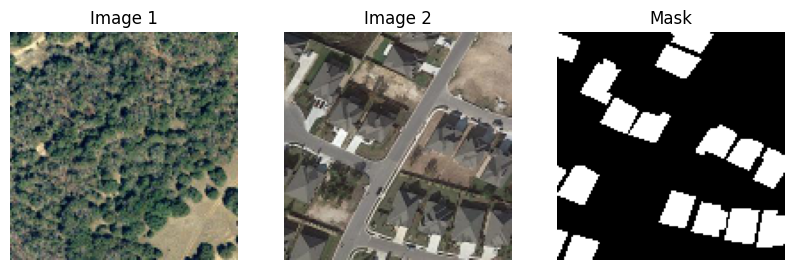

In [9]:
visualize_sample(train_dset, random.randint(0, len(train_dset)) 

### ChangeDetection with ViT

In [10]:
class Downsampling(nn.Module):
    def __init__(self, in_channels, out_channels, initial=False):
        super(Downsampling, self).__init__()
        if initial:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=(3,3))
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=(1,1))
        self.norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(2).transpose(1, 2)
        x= self.norm(x)
        return x

class Transformer(nn.Module):
    def __init__(self, dim, reduction_ratio, num_heads=8):
        super(Transformer, self).__init__()
        self.dim = dim
        self.num_heads = num_heads

        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.reduce_dim = nn.Linear(dim * reduction_ratio, dim)
        self.mlp = nn.Linear(dim, dim)
        self.conv3x3 = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.norm = nn.LayerNorm(dim)
        self.activation = nn.GELU()

    def forward(self, x):
        batch_size, HW, C = x.shape
        H = W = int(torch.sqrt(torch.tensor(HW)))

        attn_output, _ = self.attention(x, x, x) #тензор уваги, матриця уваги

        x = x + attn_output
        x = x.view(batch_size, H, W, C)
        x = self.norm(x)

        x = self.mlp(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3x3(x)
        x = x.permute(0, 2, 3, 1)
        x = self.activation(x)
        x = self.mlp(x) + x

        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)
        
        return x

class Encoder(nn.Module):
    def __init__(self, input_channels, embedding_dim):
        super(Encoder, self).__init__()
        
        self.encoder_blocks = nn.ModuleList([
            Downsampling(input_channels, embedding_dim, initial=True),
            Transformer(embedding_dim, reduction_ratio=2),
            Downsampling(embedding_dim, embedding_dim * 2),
            Transformer(embedding_dim * 2, reduction_ratio=4)
            # Downsampling(embedding_dim * 2, embedding_dim * 4),
            # Transformer(embedding_dim * 4, reduction_ratio=8),
        ])

    def forward(self, x):
        features = []
        for block in self.encoder_blocks:
            x = block(x)
            if isinstance(block, Transformer):
                features.append(x)
        return features

class Decoder(nn.Module):
    def __init__(self, in_channels_list, embedding_dim, device="cpu"):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.device = device

        self.fusion = nn.Conv2d(in_channels=self.embedding_dim*len(in_channels_list), out_channels=self.embedding_dim, kernel_size=1)
        self.upsample = nn.ConvTranspose2d(embedding_dim, embedding_dim, kernel_size=4, stride=2, padding=1)
        self.residual = nn.Sequential(
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.probability = nn.Conv2d(embedding_dim, 1, kernel_size=3, padding=1)
        self.activation = nn.Sigmoid()
        
    def conv_diff(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def make_prediction(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def transform(self, inputs):
        target_size = inputs[0].shape[2:] 
        resized_inputs = [
            F.interpolate(x, size=target_size, mode='bilinear', align_corners=False) if x.shape[2:] != target_size else x
            for x in inputs
        ]
        return resized_inputs

    def forward(self, pre_features, post_features):
        B, C, H, W = pre_features[0].shape
        pre_features = self.transform(pre_features) 
        post_features = self.transform(post_features)

        upsampled = []
        for i in range(len(pre_features)): 
            pre_feature = pre_features[i].flatten(2).transpose(1, 2)
            pre_feature = nn.Linear(pre_features[i].shape[1],256).to(self.device)(pre_feature)        
            pre_feature = pre_feature.view(B, H, W, -1).permute(0, 3, 1, 2) 

            post_feature = post_features[i].flatten(2).transpose(1, 2)
            post_feature = nn.Linear(post_features[i].shape[1],256).to(self.device)(post_feature)   
            post_feature = post_feature.view(B, H, W, -1).permute(0, 3, 1, 2)
            
            cat = torch.cat((pre_feature,post_feature),dim=1)
            diff = self.conv_diff(cat.shape[1],cat.shape[1]//2).to(self.device)(cat)
            
            upsampled.append(diff)
            
        cat = torch.cat(upsampled, dim=1)
        c = self.fusion(cat)
        c = self.upsample(c)
        c = self.residual(c) + c * 0.1  # Residual connection
        c = self.probability(c)
        с = self.activation(c) 
        return с
        
class ChangeViT(nn.Module):
    def __init__(self, input_channels, embedding_dim, device = "cpu"):
        super(ChangeViT, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder = Encoder(input_channels, embedding_dim)
        self.decoder = Decoder(in_channels_list=[embedding_dim, embedding_dim * 2], embedding_dim=256, device=device)

    def forward(self, inputs):
        pre_img = inputs[:,0,:,:,:]
        post_img = inputs[:,1,:,:,:]
        
        pre_features = self.encoder(pre_img)
        post_features = self.encoder(post_img)
        
        change_map = self.decoder(pre_features,post_features)
        # print(change_map.shape)
        # print(change_map)
        
        return change_map

##### Train model

In [11]:
def train_model_with_cross_validation(model, dataset, optimizer, criterion, num_epochs=50, k_folds=5, device='cuda'):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=4, shuffle=False)

        optimizer.zero_grad()

        for epoch in range(num_epochs):
            model.train() 
            running_loss = 0.0

            for batch in train_loader:
                inputs = batch['x'].to(device)
                labels = batch['mask'].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                # print('outputs: ',outputs.shape)
                # print(outputs)
                loss = criterion(outputs, labels)
                # print(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

            torch.cuda.empty_cache()
        
        model.eval()  
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['x'].to(device)
                labels = batch['mask'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Fold {fold + 1}, Validation Loss: {avg_val_loss}")
        fold_results.append(avg_val_loss)

    avg_loss = sum(fold_results) / k_folds
    print('Average Loss: ', avg_loss)

    return fold_results

In [18]:
gc.collect()
model = ChangeViT(input_channels=3, embedding_dim=16, device=device).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_model_with_cross_validation(model, train_dset, optimizer, criterion, num_epochs=3, k_folds=4, device=device)

Fold 1/4
Epoch 1/3, Loss: 0.19567580197727635
Epoch 2/3, Loss: 0.17546824017000656
Epoch 3/3, Loss: 0.15949794513250343
Fold 1, Validation Loss: 0.14242376651242836
Fold 2/4
Epoch 1/3, Loss: 0.1409501639915193
Epoch 2/3, Loss: 0.12790555626202177
Epoch 3/3, Loss: 0.11858659380556158
Fold 2, Validation Loss: 0.11670973203598571
Fold 3/4
Epoch 1/3, Loss: 0.11311778097929862
Epoch 2/3, Loss: 0.10971566246281501
Epoch 3/3, Loss: 0.10519269518202046
Fold 3, Validation Loss: 0.10626720604871465
Fold 4/4
Epoch 1/3, Loss: 0.10376856230567578
Epoch 2/3, Loss: 0.10014895324936336
Epoch 3/3, Loss: 0.09876510063070494
Fold 4, Validation Loss: 0.10638916039490284
Average Loss:  0.11794746624800789


[0.14242376651242836,
 0.11670973203598571,
 0.10626720604871465,
 0.10638916039490284]

In [19]:
torch.save(model.state_dict(), "model_last.pth")

In [9]:
model = ChangeViT(input_channels=3, embedding_dim=16, device=device).to(device)
model.load_state_dict(torch.load("/kaggle/input/model_last/pytorch/default/1/model_last.pth", weights_only=True))
# model2.eval()

<All keys matched successfully>

In [ ]:
# train_loader = DataLoader(train_dset, shuffle = True)
# test_loader = DataLoader(test_dset)

### Evaluate model

In [20]:
def evaluate_model(model, test_loader):
    model.eval() 
    total_loss = 0.0
    with torch.no_grad():
        for i in range(len(test_loader)):
            images = test_loader.dataset[i]['x'].unsqueeze(0).to(device) 
            masks = test_loader.dataset[i]['mask'].unsqueeze(0).to(device).float()  
            outputs = model(images)
            loss = criterion(outputs, masks) 
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print('Average Test Loss: ', avg_loss)

In [21]:
test_loader = DataLoader(test_dset)

In [22]:
evaluate_model(model, test_loader)

Average Test Loss:  0.11595338452476928


In [10]:
def find_threshold(y_true, y_pred,print_=False):
    precision, recall, thresholds = precision_recall_curve(y_true.ravel(), y_pred.ravel())
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9) 

    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1 = f1_scores[best_threshold_index]

    if(print_):
        print(f'Best Threshold: {best_threshold}')
        print(f'Best F1 Score: {best_f1}')
    return best_threshold, best_f1

def draw(output_binary,mask,image):
    output_binary = output_binary.squeeze(0) 
    mask = mask.squeeze(0) 
    image = image.squeeze(0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title('Original T1')
    plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0)) 
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Original T2')
    plt.imshow(image[1].cpu().numpy().transpose(1, 2, 0)) 
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('True Mask')
    plt.imshow(mask.cpu(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Predicted Mask (Thresholded)')
    plt.imshow(output_binary.cpu(), cmap='gray')
    plt.axis('off')

    plt.show()

In [11]:
def compute_metrics(true_mask, pred_mask,print_=False):
    true_mask = true_mask.flatten().cpu().numpy()
    pred_mask = pred_mask.flatten().cpu().numpy()

    cm = confusion_matrix(true_mask, pred_mask)

    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    accuracy = accuracy_score(true_mask, pred_mask)
    precision = precision_score(true_mask, pred_mask, zero_division=1)
    recall = recall_score(true_mask, pred_mask, zero_division=1)
    f1 = f1_score(true_mask, pred_mask, zero_division=1)
    iou = jaccard_score(true_mask, pred_mask, zero_division=1)
    mcc = matthews_corrcoef(true_mask, pred_mask)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = balanced_accuracy_score(true_mask, pred_mask)
    kappa = cohen_kappa_score(true_mask, pred_mask)
    oa = (tp + tn) / (tn + fp + fn + tp)

    if (print_):
        print('Confusion Matrix:\n', cm)
        print('Metrics:')
        print('Accuracy: ', accuracy)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 Score: ', f1)
        print('IoU: ', iou)
        print('MCC: ', mcc)
        print('Specificity: ', specificity)
        print('Balanced Accuracy: ', balanced_accuracy)
        print('Cohen\'s Kappa: ', kappa)
        print('Overall Accuracy: ', oa)

    return accuracy, precision, recall, f1, iou, mcc, specificity, balanced_accuracy, kappa

In [12]:
def evaluate_single_image(model, image, mask):
    model.eval() 
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  
        mask = mask.unsqueeze(0).to(device)

        output = model(image) 
    
        output_flat = output.view(-1).cpu().numpy()  
        mask_flat = (mask.view(-1).cpu().numpy() > 0).astype(np.float32) 

        best_threshold, best_f1 = find_threshold(mask_flat, output_flat, True)
        
        # best_threshold = best_threshold
        output_binary = (output > best_threshold).int()
        print(output_binary)

        output_binary = output_binary.squeeze(0) 
        # print(output_binary.shape)
        mask = mask.squeeze(0) 
        image = image.squeeze(0)

        draw(output_binary,mask,image)

        compute_metrics(mask,output_binary,print_=True)

154
Best Threshold: 0.22257986664772034
Best F1 Score: 0.5999999995007614
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


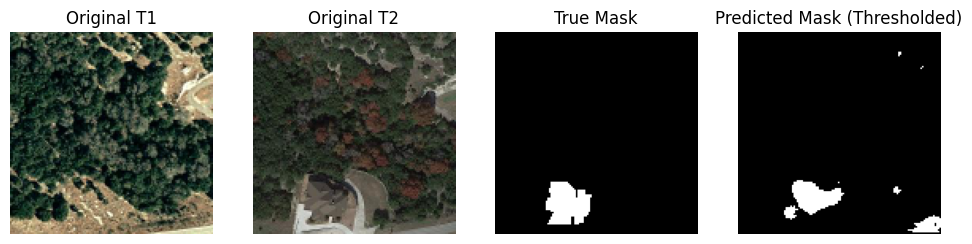

Confusion Matrix:
 [[15523   270]
 [  223   368]]
Metrics:
Accuracy:  0.96990966796875
Precision:  0.5768025078369906
Recall:  0.622673434856176
F1 Score:  0.5988608624898292
IoU:  0.4274099883855981
MCC:  0.5837140525778536
Specificity:  0.9829038181472805
Balanced Accuracy:  0.8027886265017282
Cohen's Kappa:  0.5832531723027043
Overall Accuracy:  0.96990966796875


In [13]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

2769
Best Threshold: 0.042668286710977554
Best F1 Score: 0.5737332992247621
tensor([[[[0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 1,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 0, 1, 1]]]], device='cuda:0', dtype=torch.int32)


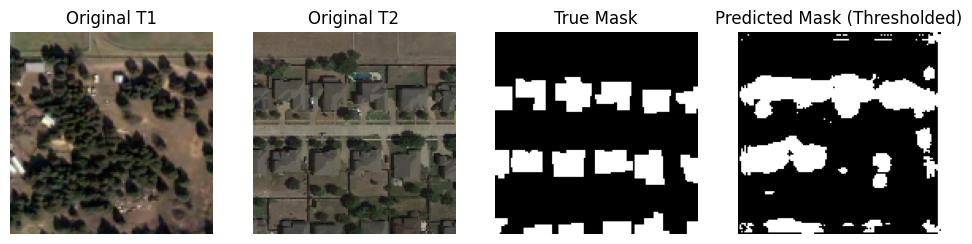

Confusion Matrix:
 [[10726  1945]
 [ 1438  2275]]
Metrics:
Accuracy:  0.79351806640625
Precision:  0.5390995260663507
Recall:  0.6127120926474549
F1 Score:  0.5735535106517081
IoU:  0.40208554259455637
MCC:  0.4396293645354738
Specificity:  0.846499881619446
Balanced Accuracy:  0.7296059871334504
Cohen's Kappa:  0.4380676242616429
Overall Accuracy:  0.79351806640625


In [14]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

248
Best Threshold: 0.27453452348709106
Best F1 Score: 0.8499823503648092
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


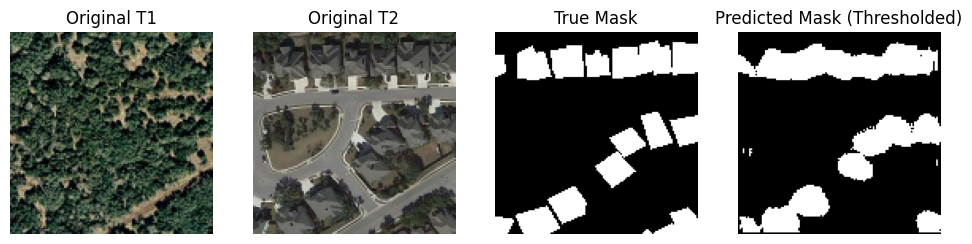

Confusion Matrix:
 [[11497   645]
 [  631  3611]]
Metrics:
Accuracy:  0.922119140625
Precision:  0.8484492481203008
Recall:  0.8512494106553512
F1 Score:  0.8498470228289008
IoU:  0.7388991201145897
MCC:  0.7972739920125526
Specificity:  0.9468786031955196
Balanced Accuracy:  0.8990640069254354
Cohen's Kappa:  0.7972720197703472
Overall Accuracy:  0.922119140625


In [15]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

1941
Best Threshold: 0.2628301978111267
Best F1 Score: 0.77839555152574
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


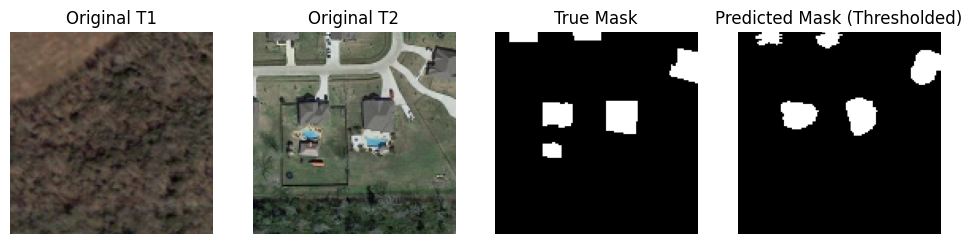

Confusion Matrix:
 [[14846   247]
 [  312   979]]
Metrics:
Accuracy:  0.96588134765625
Precision:  0.7985318107667211
Recall:  0.7583268783888458
F1 Score:  0.7779102105681367
IoU:  0.6365409622886866
MCC:  0.7597421024238833
Specificity:  0.983634797588286
Balanced Accuracy:  0.870980837988566
Cohen's Kappa:  0.759444830661606
Overall Accuracy:  0.96588134765625


In [16]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

926
Best Threshold: 0.201720729470253
Best F1 Score: 0.8060915621193196
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


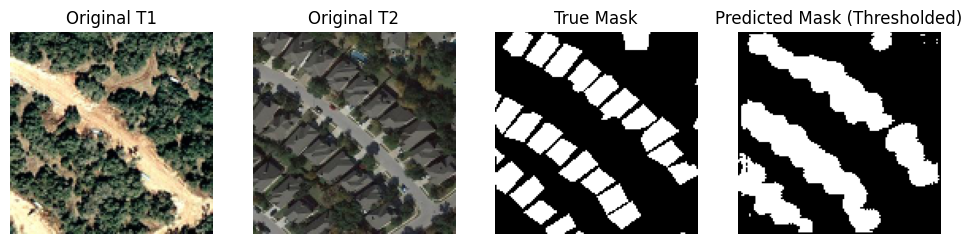

Confusion Matrix:
 [[10073  1271]
 [  780  4260]]
Metrics:
Accuracy:  0.87481689453125
Precision:  0.7702043030193455
Recall:  0.8452380952380952
F1 Score:  0.8059786207548955
IoU:  0.6750118840120425
MCC:  0.71555335452991
Specificity:  0.8879583921015515
Balanced Accuracy:  0.8665982436698234
Cohen's Kappa:  0.7138727229082036
Overall Accuracy:  0.87481689453125


In [17]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

1978
Best Threshold: 0.42963844537734985
Best F1 Score: 0.5057603681636004
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


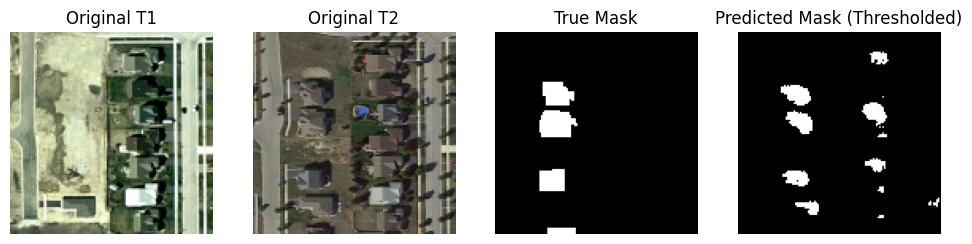

Confusion Matrix:
 [[15087   432]
 [  427   438]]
Metrics:
Accuracy:  0.94757080078125
Precision:  0.503448275862069
Recall:  0.5063583815028901
F1 Score:  0.5048991354466859
IoU:  0.33770239013107173
MCC:  0.47722137624460614
Specificity:  0.9721631548424512
Balanced Accuracy:  0.7392607681726706
Cohen's Kappa:  0.4772191667960569
Overall Accuracy:  0.94757080078125


In [18]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

1036
Best Threshold: 0.11441977322101593
Best F1 Score: 0.6385084964497898
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


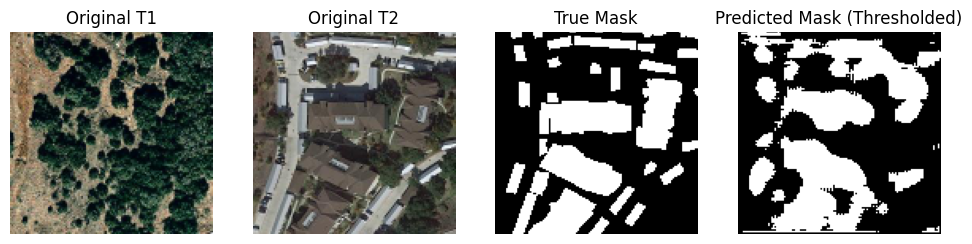

Confusion Matrix:
 [[8132 2583]
 [1800 3869]]
Metrics:
Accuracy:  0.73248291015625
Precision:  0.5996590204587725
Recall:  0.682483683189275
F1 Score:  0.6383961719330089
IoU:  0.46885603490063016
MCC:  0.42976945525002647
Specificity:  0.7589360709286047
Balanced Accuracy:  0.7207098770589399
Cohen's Kappa:  0.4275159790891554
Overall Accuracy:  0.73248291015625


In [19]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

64
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])
Best Threshold: 0.36197033524513245
Best F1 Score: 0.8537753217844453
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32)


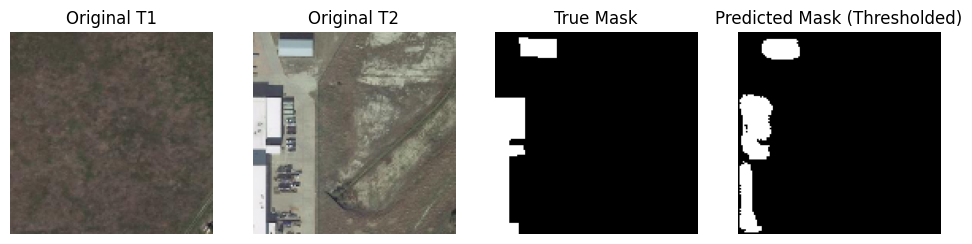

Confusion Matrix:
 [[14828   143]
 [  255  1158]]
Metrics:
Accuracy:  0.9757080078125
Precision:  0.8900845503458877
Recall:  0.8195329087048833
F1 Score:  0.8533529845246869
IoU:  0.7442159383033419
MCC:  0.8409861859150503
Specificity:  0.9904481998530492
Balanced Accuracy:  0.9049905542789662
Cohen's Kappa:  0.8401347403930663
Overall Accuracy:  0.9757080078125


In [20]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
print(mask)
evaluate_single_image(model, images, mask)

In [24]:
def evaluate_model_metrics(model, test_loader, device):
    model.eval() 
    running_loss = 0.0

    criterion = torch.nn.BCELoss() 
    all_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'iou': [],
        'mcc': [],
        'specificity': [],
        'balanced_accuracy': [],
        'kappa': []
    }

    with torch.no_grad():
        for sample in test_loader:
            inputs = sample['x'].to(device) 
            labels = sample['mask'].to(device)  

            output = model(inputs)
            loss = criterion(output, labels.float())
            running_loss += loss.item()

            true_mask = labels.cpu().numpy()
            pred_mask = output.cpu().numpy()

            best_threshold, best_f1 = find_threshold(true_mask, pred_mask)
            output_binary = (output > best_threshold).int()

            accuracy, precision, recall, f1, iou, mcc, specificity, balanced_accuracy, kappa = compute_metrics(labels, output_binary)

            all_metrics['accuracy'].append(accuracy)
            all_metrics['precision'].append(precision)
            all_metrics['recall'].append(recall)
            all_metrics['f1'].append(f1)
            all_metrics['iou'].append(iou)
            all_metrics['mcc'].append(mcc)
            all_metrics['specificity'].append(specificity)
            all_metrics['balanced_accuracy'].append(balanced_accuracy)
            all_metrics['kappa'].append(kappa)
                
    avg_loss = running_loss / len(test_loader)
    avg_metrics = {metric: sum(values) / len(values) for metric, values in all_metrics.items()}

    print('Test Loss: ', avg_loss)
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value}")

In [25]:
evaluate_model_metrics(model, test_loader, device)

Test Loss:  0.11468633913651928
Accuracy: 0.805473235967948
Precision: 0.4504278666621144
Recall: 0.6811973810295413
F1: 0.4834992374696157
Iou: 0.36305454419688607
Mcc: 0.4574002988790325
Specificity: 0.8711770150117096
Balanced_accuracy: 0.7561871980206264
Kappa: 0.43887631647353594
